# Get crystal structures Metadata from PDB
- This notebook allows to download a pdb id associated metadata.
- The metadata from the pdb ids belonging to the target protein are gathered into a dataframe named: `TABLA_MTDATA_{prot_name}_{number_of_structures}_crys.json` 

In [2]:
from pathlib import Path
from glob import glob
import pandas as pd
import pickle
import json
import sys
import pypdb
from Bio import pairwise2, SeqIO
sys.path.insert(0, '../..')
from helper_modules.get_pdb_ids_from_uniport import *
from helper_modules.find_gaps import *

## Protein data

### Inputs
This notebook requires to specify the following values
- `prot_name`: the name of the protein.
- `uniprot_id`: Uniprot Accession number.
- `ref_struc_id`: PDB id of the reference structure.
- `ref_ligand_name`: Three letters name of the cocrystalized ligand in the reference structure.


In [3]:
prot_name       = 'egfr'
uniprot_id      = 'P00533'
ref_struc_id    = '7a2a'
ref_ligand_name = '7G9'

### Get the protein sequence

In [4]:
seq_prot = get_seq_from_uniprot(uniprot_id)
print(seq_prot)
print(f'\nThere are {len(seq_prot)} residues.')

MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVVALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGICLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAARNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSYGVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPKFRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRA

### Get the pdbids of the downloaded structures

In [5]:
# Get the pdbids and some metadata from uniprot
df_pdb_ids = pdb_ids_from_uniprot(uniprot_id)

# Get the reference structure and its sequence and residue positions
seq_cry, positions_cry = get_structure_sequence(ref_struc_id)
print(positions_cry[0], positions_cry[-1])

# Select only those entries that include the binding site
df_sel_pdbids = get_useful_pdbids(df_pdb_ids, 
                                  positions_cry,
                                  thr_tol = (3,3))

# Get the list of input files
INPUT_DIR = f'./pdb_structures/pdb_chains'
pdbids_list = [i.split('/')[-1].split('_')[0] for i in sorted(glob(f'{INPUT_DIR}/*pdb'))]
n_pdb_id    = len(pdbids_list)
# Update selection only those ids which files were downloaded
df_sel_pdbids = df_sel_pdbids[df_sel_pdbids.pdb_id.isin(pdbids_list)]

700 984


In [6]:
df_sel_pdbids

,pdb_id,method,resolution,chain,start,end,seq_len
1,1m14,X-ray,2.60,A,695,1022,328
2,1m17,X-ray,2.60,A,695,1022,328
5,1xkk,X-ray,2.40,A,695,1022,328
8,2eb2,X-ray,2.50,A,695,1022,328
9,2eb3,X-ray,2.84,A,695,1022,328
...,...,...,...,...,...,...,...
216,6vhn,X-ray,2.40,A,696,1022,327
217,6vhp,X-ray,3.60,A,696,1022,327
218,6z4b,X-ray,2.50,A,695,1022,328
219,6z4d,X-ray,2.00,A,695,1022,328


### Get the available metadata

In [7]:
mtdat_pkl_file = f"./MTDATA_{prot_name.upper()}_{n_pdb_id}_crys.pkl"

# If the dictionary already exists, load it!
if Path(mtdat_pkl_file).exists():
    with open(mtdat_pkl_file, 'rb') as f:
        prot_crys_mtd_dict = pickle.load(f)
else:  
    # Create an empty dict to fill it with the pdbs metadata
    prot_crys_mtd_dict = {}
    for i, (pdb_id, chain) in df_sel_pdbids[['pdb_id', 'chain']].iterrows():
        print(i, '->', pdb_id)
        # Get the metadata using pypdb and in-house functions
        descrip_pdb = pypdb.describe_pdb(pdb_id)
        cristal = pypdb.get_entity_info(pdb_id)
        ligs_names = get_bounded_ligands(pdb_id)
        num_ligs = len(ligs_names)
        secuencia = get_pdb_sequence(pdb_id)
        # Find number of gaps and coverage 
        seq_alg, coverage, gaps = get_gaps_and_coverage(
                                    pdb_file = f'./pdb_structures/pdb_chains/{pdb_id}_A.pdb', 
                                    full_sequence = seq_prot,
                                    chain = 'A') # Hardcoded as the chain was renamed in the previous notebook
        identity = get_identity(seq_alg, seq_prot, gap_char = '-') 
        prot_crys_mtd_dict.update(
            {pdb_id : 
                 {'describe_pdb': descrip_pdb, 
                  'pdb_info': cristal, 
                  'identity': identity,
                  'num_ligs': num_ligs, 
                  'name_ligs': ligs_names,
                  'seq': secuencia,
                  'seq_alg': seq_alg, 
                  'coverage': coverage,
                  'gaps': gaps,
                  'chain': chain
                 }
            })
    # Save the dict as a json file
    with open(mtdat_pkl_file, 'wb') as file:
        pickle.dump(prot_crys_mtd_dict, file)

## Create the final Metadata table

In [8]:
def get_data_rows(pdb_entry: dict) -> pd.Series:
    '''
    This function takes a pdb_entry dictionary, 
    nested in `prot_crys_mtd_dict` created in the previous cell,
    and returns a pandas series containing the entry metadata
    '''
    e = pdb_entry
    d = e['describe_pdb']
    l = e

    dic = {"PDB_ID"    : d['rcsb_id'].lower(),
          "Title"      : d['citation'][0]['title'].lower(),
          "Entities"   : d['pdbx_vrpt_summary']['protein_dnarnaentities'],
          "ChainID"    : e['chain'],
          "Identity"   : round(e['identity'], 3),
          "Coverage"   : round(e['coverage'], 3),
          "NumGaps"    : e['gaps']['num_gaps'],
          "GapLen"     : e['gaps']['gap_lengths'],
          "GapPos"     : e['gaps']['gap_list'],
          "Resolution" : d['pdbx_vrpt_summary']['pdbresolution'],
          "Date"       : d['rcsb_accession_info']['initial_release_date'].split('T')[0],
          "NumLigs"    : e['num_ligs'], 
          "NameLigs"   : e['name_ligs']
          }
    entry_series = pd.Series(dic)
    return entry_series

def get_mtd_table(dic: dict):
    '''
     This function is designed to take the 
     `prot_crys_mtd_dict` dictionary
     and extract a pandas series for each pdb entry
    '''
    df = pd.DataFrame()
    for pdb_id in dic.keys():
        row = get_data_rows(dic[pdb_id])
        df = df.append(row, ignore_index=True)
    return df

In [18]:
# Now we create the dataframe
df_prot = get_mtd_table(prot_crys_mtd_dict).sort_values("PDB_ID").set_index("PDB_ID")

# Reorder the columns
df_prot = df_prot[['Title','Date', 'Entities', 'ChainID','Resolution', 
         'Identity', 'Coverage', 'NumGaps', 'GapLen', 'GapPos',
         'NumLigs', 'NameLigs']]
df_prot

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs
PDB_ID,,,,,,,,,,,,
1m14,structure of the epidermal growth factor \nrec...,2002-09-04,1,A,2.60,1.000,23.058,2.0,"[695, 236]","[[1, 695], [975, 1210]]",0.0,[]
1m17,structure of the epidermal growth factor \nrec...,2002-09-04,1,A,2.60,1.000,23.058,2.0,"[695, 236]","[[1, 695], [975, 1210]]",1.0,[AQ4]
1xkk,a unique structure for epidermal growth factor...,2004-12-07,1,A,2.40,0.936,19.256,5.0,"[701, 4, 4, 8, 260]","[[1, 701], [734, 737], [750, 753], [867, 874],...",2.0,"[FMM, PO4]"
2eb2,structural basis for the altered drug sensitiv...,2008-02-12,1,A,2.50,0.980,20.661,5.0,"[695, 3, 1, 1, 260]","[[1, 695], [721, 723], [749, 749], [866, 866],...",0.0,[]
2eb3,structural basis for the altered drug sensitiv...,2008-02-12,1,A,2.84,0.941,19.835,4.0,"[695, 1, 14, 260]","[[1, 695], [721, 721], [862, 875], [951, 1210]]",1.0,[ANP]
...,...,...,...,...,...,...,...,...,...,...,...,...
6vhn,structural basis for egfr mutant inhibition by...,2020-04-22,1,A,2.40,0.929,19.587,4.0,"[695, 5, 13, 260]","[[1, 695], [747, 751], [863, 875], [951, 1210]]",1.0,[QQJ]
6vhp,structural basis for egfr mutant inhibition by...,2020-04-22,1,A,3.60,0.980,20.661,3.0,"[695, 5, 260]","[[1, 695], [866, 870], [951, 1210]]",1.0,[QP1]
6z4b,complex crystal structures of egfr with third-...,2020-11-11,1,A,2.50,0.952,19.752,3.0,"[699, 12, 260]","[[1, 699], [863, 874], [951, 1210]]",3.0,"[SO4, Q6K, 9LL]"


## Save the metadata Dataframe to a file

In [19]:
n_pdb_id_to_use = len(df_prot)
dataframe_file = f"./TABLA_MTDATA_{prot_name.upper()}_{n_pdb_id_to_use}_crys.json"
if not Path(dataframe_file).exists:
    df_prot.to_json(dataframe_file)

## Data exploration

In [11]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1.2, style = 'white')

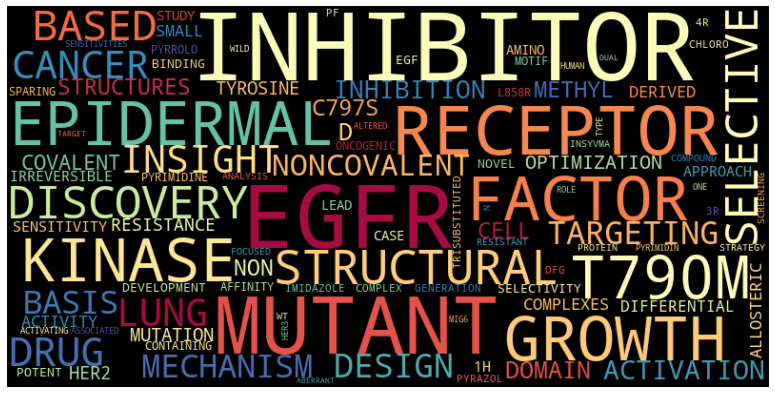

In [12]:
text = " ".join(titulo for titulo in df_prot.Title)
text = text.replace('-', ' ').upper()

stopwords = set(STOPWORDS)
stopwords.update([ "structure", "ray", "crystal", "yl"])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = stopwords, 
                      max_font_size = 100, 
                      collocations = False, 
                      min_font_size = 4,
                      contour_width = 100, 
                      colormap = "Spectral", 
                      random_state = 15,
                      max_words = 100, 
                      width=800, height=400,
                      background_color = "black").generate(text)

plt.figure(figsize = (16, 7))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [13]:
def plot_property(prop, color = 'red', title = ''):
    df_prot[prop] = df_prot[prop].astype(float)
    fig, ax = plt.subplots(figsize = (8, 5))
    sns.histplot(df_prot[prop] , 
                 color = color, 
                 kde = True,
                 label = prop,
                 ax = ax)
    plt.legend()
    plt.title(title)
    plt.show()

[Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Number of structures published by year')]

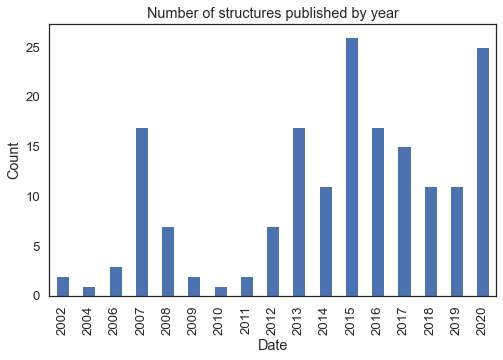

In [14]:
df_prot.Date = pd.to_datetime(df_prot.Date)
df_prot_dates = df_prot.set_index('Date')
df_prot_dates.tail()
fig, ax = plt.subplots(figsize = (8, 5))
ax = df_prot.groupby(df_prot.Date.dt.year)['Date'].count().plot(kind='bar')
ax.set(ylabel = 'Count', title = 'Number of structures published by year')

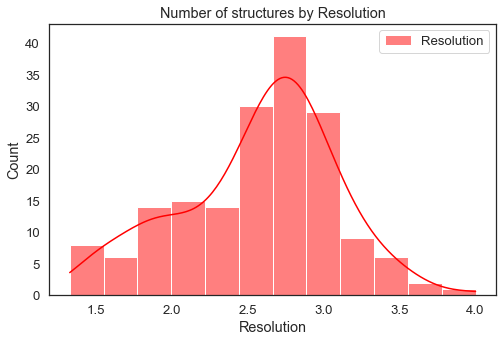

In [15]:
prop = 'Resolution'
plot_property(prop, title = f'Number of structures by {prop}')

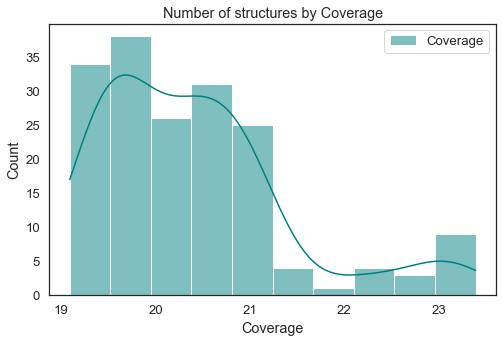

In [16]:
prop = 'Coverage'
plot_property(prop, color = 'teal',
             title = f'Number of structures by {prop}')

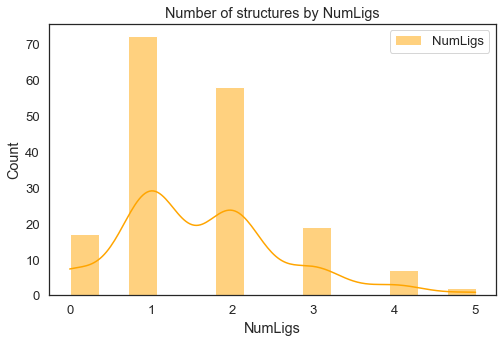

In [17]:
prop = 'NumLigs'
plot_property(prop, color = 'orange',
              title = f'Number of structures by {prop}')